# Subtype predictor -- single cell QC

In this file I will QC the HGSC single cell data from 

cell type calls are from the authors

data is from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE165897


manuscript of data: Longitudinal single-cell RNA-seq analysis reveals stress-promoted chemoresistance in metastatic ovarian cancer

I will make the typical QC plots, then write it out for making pseudobulks

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

data_path = f"{os.getcwd()}/../../data/single_cell/"

result_ad_file = f"{data_path}/GSE165897_processed/GSE165897_processed.h5ad"


2025-01-08 13:42:05.567619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 13:42:05.568353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 13:42:05.570226: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 13:42:05.575514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736368925.583822 2485147 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736368925.58

scanpy==1.10.4 anndata==0.8.0 umap==0.5.2 numpy==1.26.0 scipy==1.14.1 pandas==1.5.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [4]:
# read in the expression
expr_df = pd.read_csv(f"{data_path}/GSE165897_RAW/GSE165897_UMIcounts_HGSOC.tsv.gz", index_col=0, sep="\t")



AAACCTGCAGGTTTCA-EOC372_pPer  AAACCTGGTCCGAATT-EOC372_pPer  \
RP11-34P13.7                              0                             0   
RP11-34P13.8                              0                             0   
CICP27                                    0                             0   
RP11-34P13.15                             0                             0   
RP11-34P13.13                             0                             0   
...                                     ...                           ...   
MT-ND6                                    4                             1   
MT-TE                                     0                             0   
MT-CYB                                   30                           136   
MT-TT                                     0                             0   
MT-TP                                     0                             0   

               AAAGATGCATCTGGTA-EOC372_pPer  AAAGTAGTCGCTTAGA-EOC372_pPer  \
RP11-34P13.7                              0                             0   
RP11-34P13.8                              0                             0   
CICP27                                    0                             0   
RP11-34P13.15                             0                             0   
RP11-34P13.13                             0                             0   
...                                     ...                           ...   
MT-ND6                                    0                             0   
MT-TE                                     0                             0   
MT-CYB                                   93                            78   
MT-TT                                     0                             0   
MT-TP                                     0                             0   

               AAATGCCAGGTGCACA-EOC372_pPer  AAATGCCAGTACGATA-EOC372_pPer  \
RP11-34P13.7                              0                             0   
RP11-34P13.8                              0                             0   
CICP27                                    0                             0   
RP11-34P13.15                             0                             0   
RP11-34P13.13                             0                             0   
...                                     ...                           ...   
MT-ND6                                    4                             0   
MT-TE                                     0                             0   
MT-CYB                                   89                             1   
MT-TT                                     0                             0   
MT-TP                                     0                             0   

               AACCATGCACGTTGGC-EOC372_pPer  AACTCAGGTACATCCA-EOC372_pPer  \
RP11-34P13.7                              0                             0   
RP11-34P13.8                              0                             0   
CICP27                                    0                             0   
RP11-34P13.15                             0                             0   
RP11-34P13.13                             0                             0   
...                                     ...                           ...   
MT-ND6                                   15                             1   
MT-TE                                     0                             0   
MT-CYB                                  266                            27   
MT-TT                                     0                             0   
MT-TP                                     2                             0   

               AACTCCCGTAAACACA-EOC372_pPer  AACTCCCTCCAAAGTC-EOC372_pPer  \
RP11-34P13.7                              0                             0   
RP11-34P13.8                              0                             0   
CICP27                                    0                             0   
RP11-34

In [28]:
# make anndata
expr_df = expr_df.T
all_adata = ad.AnnData(X=expr_df.values, obs=pd.DataFrame(index=expr_df.index), var=pd.DataFrame(index=expr_df.columns))
all_adata

/tmp/ipykernel_2485147/108822213.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  all_adata = ad.AnnData(X=expr_df.values, obs=pd.DataFrame(index=expr_df.index), var=pd.DataFrame(index=expr_df.columns))


AnnData object with n_obs × n_vars = 51786 × 32847

# format metadata

In [29]:
# read in the metadata
meta_cell_path = f"{data_path}/GSE165897_metadata/GSE165897_cellInfo_HGSOC.tsv"
meta_samp_path = f"{data_path}/GSE165897_metadata/GSE165897_sample_metadata.csv"

# read in tables
meta_cell_df = pd.read_csv(meta_cell_path, sep="\t")
meta_samp_df = pd.read_csv(meta_samp_path)


# merge the metadata
meta_cell_df["Barcode"] = meta_cell_df["cell"]
meta_cell_df.index = meta_cell_df["Barcode"]
merged_df = pd.merge(meta_cell_df, meta_samp_df, left_on=['samp_id', 'donor_id'], right_on=['samp_id', 'donor_id'])

# remove duplicates
cell_barcode_keep = pd.Series(merged_df["Barcode"]).drop_duplicates(keep=False)
merged_df = merged_df.iloc[np.where(merged_df["Barcode"].isin(cell_barcode_keep))[0]]
all_adata = all_adata[np.where(all_adata.obs.index.isin(cell_barcode_keep))[0],:]

# order the obs in the same order
merged_df.index = merged_df["Barcode"]
left_df, right_df = merged_df.align(all_adata.obs, join="inner", axis=0)
left_df

merged_df.index = merged_df["Barcode"]

#inner: use intersection of keys from both frames, preserve the order of the left keys.
left_df, right_df = all_adata.obs.align(merged_df, join="inner", axis=0)

# now keeping the same ordering as the original obs
# replace the obs DF
all_adata = all_adata[left_df.index, :]
all_adata.obs = right_df


In [30]:
all_adata.obs

cell  \
AAACCTGCAGGTTTCA-EOC372_pPer  AAACCTGCAGGTTTCA-EOC372_pPer   
AAACCTGGTCCGAATT-EOC372_pPer  AAACCTGGTCCGAATT-EOC372_pPer   
AAAGATGCATCTGGTA-EOC372_pPer  AAAGATGCATCTGGTA-EOC372_pPer   
AAAGTAGTCGCTTAGA-EOC372_pPer  AAAGTAGTCGCTTAGA-EOC372_pPer   
AAATGCCAGGTGCACA-EOC372_pPer  AAATGCCAGGTGCACA-EOC372_pPer   
...                                                    ...   
TTTGCGCCACATCCAA-EOC443_pOme  TTTGCGCCACATCCAA-EOC443_pOme   
TTTGCGCCACGTCAGC-EOC443_pOme  TTTGCGCCACGTCAGC-EOC443_pOme   
TTTGCGCCATTCACTT-EOC443_pOme  TTTGCGCCATTCACTT-EOC443_pOme   
TTTGTCACATTGGGCC-EOC443_pOme  TTTGTCACATTGGGCC-EOC443_pOme   
TTTGTCAGTAAGGATT-EOC443_pOme  TTTGTCAGTAAGGATT-EOC443_pOme   

                                                samp_id donor_id  \
AAACCTGCAGGTTTCA-EOC372_pPer  EOC372_primary_Peritoneum   EOC372   
AAACCTGGTCCGAATT-EOC372_pPer  EOC372_primary_Peritoneum   EOC372   
AAAGATGCATCTGGTA-EOC372_pPer  EOC372_primary_Peritoneum   EOC372   
AAAGTAGTCGCTTAGA-EOC372_pPer  EOC372_primary_Peritoneum   EOC372   
AAATGCCAGGTGCACA-EOC372_pPer  EOC372_primary_Peritoneum   EOC372   
...                                                 ...      ...   
TTTGCGCCACATCCAA-EOC443_pOme     EOC443_primary_Omentum   EOC443   
TTTGCGCCACGTCAGC-EOC443_pOme     EOC443_primary_Omentum   EOC443   
TTTGCGCCATTCACTT-EOC443_pOme     EOC443_primary_Omentum   EOC443   
TTTGTCACATTGGGCC-EOC443_pOme     EOC443_primary_Omentum   EOC443   
TTTGTCAGTAAGGATT-EOC443_pOme     EOC443_primary_Omentum   EOC443   

                              treatment_phase anatomical_location cell_type  \
AAACCTGCAGGTTTCA-EOC372_pPer  treatment-naive          Peritoneum       EOC   
AAACCTGGTCCGAATT-EOC372_pPer  treatment-naive          Peritoneum       EOC   
AAAGATGCATCTGGTA-EOC372_pPer  treatment-naive          Peritoneum       EOC   
AAAGTAGTCGCTTAGA-EOC372_pPer  treatment-naive          Peritoneum       EOC   
AAATGCCAGGTGCACA-EOC372_pPer  treatment-naive          Peritoneum       EOC   
...                                       ...                 ...       ...   
TTTGCGCCACATCCAA-EOC443_pOme  treatment-naive             Omentum    Immune   
TTTGCGCCACGTCAGC-EOC443_pOme  treatment-naive             Omentum    Immune   
TTTGCGCCATTCACTT-EOC443_pOme  treatment-naive             Omentum    Immune   
TTTGTCACATTGGGCC-EOC443_pOme  treatment-naive             Omentum    Immune   
TTTGTCAGTAAGGATT-EOC443_pOme  treatment-naive             Omentum    Immune   

                              cell_subtype  nCount_RNA  nFeature_RNA  \
AAACCTGCAGGTTTCA-EOC372_pPer       EOC_C11       33538          5704   
AAACCTGGTCCGAATT-EOC372_pPer       EOC_C12       17830          3198   
AAAGATGCATCTGGTA-EOC372_pPer        EOC_C5       10002          2151   
AAAGTAGTCGCTTAGA-EOC372_pPer        EOC_C4       17820          3439   
AAATGCCAGGTGCACA-EOC372_pPer        EOC_C5       11509          2842   
...                                    ...         ...           ...   
TTTGCGCCACATCCAA-EOC443_pOme  Plasma-cells       23020          1399   
TTTGCGCCACGTCAGC-EOC443_pOme   Macrophages        3721          1284   
TTTGCGCCATTCACTT-EOC443_pOme  Plasma-cells       16416          1395   
TTTGTCACATTGGGCC-EOC443_pOme       T-cells        1784           699   
TTTGTCAGTAAGGATT-EOC443_pOme       T-cells        1556           704   

                              percent.mt                       Barcode  \
AAACCTGCAGGTTTCA-EOC372_pPer    4.561989  AAACCTGCAGGTTTCA-EOC372_pPer   
AAACCTGGTCCGAATT-EOC372_pPer   11.648906  AAACCTGGTCCGAATT-EOC372_pPer   
AAAGATGCATCTGGTA-EOC372_pPer   10.327934  AAAGATGCATCTGGTA-EOC372_pPer   
AAAGTAGTCGCTTAGA-EOC372_pPer    9.461279  AAAGTAGTCGCTTAGA-EOC372_pPer   
AAATGCCAGGTGCACA-EOC372_pPer   10.079069  AAATGCCAGGTGCACA-EOC372_pPer   
...                                  ...                           ...   
TTTGCGCCACATCCAA-EOC443_pOme    0.469157  TTTGCGCCACATCCAA-EOC443_pOme   
TTTGCGCCACGTCAGC-EOC443_pOme    4.891158  TTTGCGCCACGTCAGC-EOC443_pOme   
TTTGCGCCATTC

In [31]:
all_adata.obs.cell_subtype.value_counts()

T-cells         19835
Macrophages      6396
CAF-1            2810
B-cells          2628
Mesothelial      2264
NK               1663
CAF-2            1540
EOC_C11          1460
EOC_C8           1247
EOC_C12          1194
CAF-3            1177
EOC_C1            958
EOC_C5            792
Mast-cells        770
EOC_C2            714
EOC_C6            627
DC-1              601
Plasma-cells      580
EOC_C7            451
EOC_C4            438
EOC_C10           395
DC-2              360
pDC               289
ILC               276
EOC_C3            196
EOC_C9            132
Endothelial        72
Name: cell_subtype, dtype: int64

In [32]:
tab = all_adata.obs.groupby(['cell_subtype', 'cell_type']).size()
tab.unstack()

cell_type        EOC   Immune  Stromal
cell_subtype                          
B-cells          NaN   2628.0      NaN
CAF-1            NaN      NaN   2810.0
CAF-2            NaN      NaN   1540.0
CAF-3            NaN      NaN   1177.0
DC-1             NaN    601.0      NaN
DC-2             NaN    360.0      NaN
EOC_C1         958.0      NaN      NaN
EOC_C10        395.0      NaN      NaN
EOC_C11       1460.0      NaN      NaN
EOC_C12       1194.0      NaN      NaN
EOC_C2         714.0      NaN      NaN
EOC_C3         196.0      NaN      NaN
EOC_C4         438.0      NaN      NaN
EOC_C5         792.0      NaN      NaN
EOC_C6         627.0      NaN      NaN
EOC_C7         451.0      NaN      NaN
EOC_C8        1247.0      NaN      NaN
EOC_C9         132.0      NaN      NaN
Endothelial      NaN      NaN     72.0
ILC              NaN    276.0      NaN
Macrophages      NaN   6396.0      NaN
Mast-cells       NaN    770.0      NaN
Mesothelial      NaN      NaN   2264.0
NK               NaN   1663.0      NaN
Plasma-cells     NaN    580.0      NaN
T-cells          NaN  19835.0      NaN
pDC              NaN    289.0      NaN

In [21]:
# remove low count cells 
#ct_idx = all_adata.obs.cell_subtype.isin(["Endothelial", "pDC", "Mast-cells"])
#inverted_list = [not x for x in ct_idx]
#all_adata = all_adata[np.where(inverted_list)[0]]

#tab = all_adata.obs.groupby(['cell_subtype', 'cell_type']).size()
#tab.unstack()

cell_type        EOC   Immune  Stromal
cell_subtype                          
B-cells          NaN   2628.0      NaN
CAF-1            NaN      NaN   2810.0
CAF-2            NaN      NaN   1540.0
CAF-3            NaN      NaN   1177.0
DC-1             NaN    601.0      NaN
DC-2             NaN    360.0      NaN
EOC_C1         958.0      NaN      NaN
EOC_C10        395.0      NaN      NaN
EOC_C11       1460.0      NaN      NaN
EOC_C12       1194.0      NaN      NaN
EOC_C2         714.0      NaN      NaN
EOC_C3         196.0      NaN      NaN
EOC_C4         438.0      NaN      NaN
EOC_C5         792.0      NaN      NaN
EOC_C6         627.0      NaN      NaN
EOC_C7         451.0      NaN      NaN
EOC_C8        1247.0      NaN      NaN
EOC_C9         132.0      NaN      NaN
ILC              NaN    276.0      NaN
Macrophages      NaN   6396.0      NaN
Mast-cells       NaN    770.0      NaN
Mesothelial      NaN      NaN   2264.0
NK               NaN   1663.0      NaN
Plasma-cells     NaN    580.0      NaN
T-cells          NaN  19835.0      NaN
pDC              NaN    289.0      NaN

In [23]:
# group cell types

# reformat the cell types to be more granular
#cell_type_vec = all_adata.obs['cell_subtype'].copy()

# group_idx = np.where(cell_type_vec.isin(["EOC_C1", "EOC_C2", "EOC_C3", 
#                                           "EOC_C4", "EOC_C5", "EOC_C6",
#                                           "EOC_C7", "EOC_C8", "EOC_C9",
#                                           "EOC_C10", "EOC_C11", "EOC_C12"]) )[0] ### START HERE
# cell_type_vec[group_idx] = "EOC"

# group_idx = np.where(cell_type_vec.isin(["CAF-1", "CAF-2", "CAF-3"]) )[0] ### START HERE
# cell_type_vec[group_idx] = "CAF"

# group_idx = np.where(cell_type_vec.isin(["DC-1", "DC-2"]) )[0] ### START HERE
# cell_type_vec[group_idx] = "DC"

# all_adata.obs['cell_subtype'] = cell_type_vec

# tab = all_adata.obs.groupby(['cell_subtype', 'cell_type']).size()
# tab.unstack()

cell_type        EOC   Immune  Stromal
cell_subtype                          
B-cells          NaN   2628.0      NaN
CAF              NaN      NaN   5527.0
DC               NaN    961.0      NaN
EOC           8604.0      NaN      NaN
ILC              NaN    276.0      NaN
Macrophages      NaN   6396.0      NaN
Mast-cells       NaN    770.0      NaN
Mesothelial      NaN      NaN   2264.0
NK               NaN   1663.0      NaN
Plasma-cells     NaN    580.0      NaN
T-cells          NaN  19835.0      NaN
pDC              NaN    289.0      NaN

In [33]:
# format metadata

# reformat the cell types to be more granular
cell_type_vec = all_adata.obs['cell_type'].copy()
immune_idx = np.where(cell_type_vec.isin(["Immune"]) )[0]
cell_type_vec[immune_idx] = "immune"

stromal_idx = np.where(cell_type_vec.isin(["Stromal"]) )[0] 
cell_type_vec[stromal_idx] = "stromal"

epi_idx = np.where(cell_type_vec.isin(["EOC"]) )[0]
cell_type_vec[epi_idx] = "tumor"
all_adata.obs['celltype_granular'] = cell_type_vec

all_adata.obs['scpred_CellType'] = all_adata.obs['cell_type']
all_adata.obs['cellType'] = all_adata.obs['cell_type']

# remove cells with no cell type
all_adata = all_adata[np.where(~all_adata.obs.scpred_CellType.isna())[0]]

all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['samp_id'].astype(str)
all_adata.obs['sample_id'] = all_adata.obs['sample_id'].tolist()
all_adata.obs['stim'] = ["CTRL"]*len(all_adata.obs)


/tmp/ipykernel_2485147/3646376977.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['samp_id'].astype(str)


In [34]:
set(all_adata.obs.scpred_CellType)

{'EOC', 'Immune', 'Stromal'}

In [36]:
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType                   EOC  Immune  Stromal
sample_id                                             
Samp_EOC1005_interval_Tumor       418     660      210
Samp_EOC1005_primary_Peritoneum   487    2342      242
Samp_EOC136_interval_Omentum     2427     769      406
Samp_EOC136_primary_Mesentery     205    1329      967
Samp_EOC153_interval_Omentum      116    1820      465
Samp_EOC153_primary_Omentum       330     641      409
Samp_EOC227_interval_Omentum      174    1813       28
Samp_EOC227_primary_Omentum        57    2089       32
Samp_EOC349_interval_Omentum       66    1401        4
Samp_EOC349_primary_Peritoneum     30    1096      357
Samp_EOC372_interval_Peritoneum   131    2389     2151
Samp_EOC372_primary_Peritoneum    281     288      142
Samp_EOC3_interval_Omentum        223    1884      396
Samp_EOC3_primary_Peritoneum      203    2588      351
Samp_EOC443_interval_Omentum      103    4107      253
Samp_EOC443_primary_Omentum      1086     612      424
Samp_EOC540_interval_Omentum       18    1658      367
Samp_EOC733_interval_Omentum      372    3685       20
Samp_EOC733_primary_Peritoneum   1550     149       43
Samp_EOC87_interval_Omentum       191     999      301
Samp_EOC87_primary_Peritoneum     136    1079      295

In [41]:
# remove genes that are duplicated
all_adata.var["gene_ids"] = all_adata.var.index.to_list()
a = (all_adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

all_adata = all_adata[:, all_adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
all_adata.var.index = all_adata.var['gene_ids']


# QC everything

In [42]:
# how many of each samp
all_adata.obs["sample_id"].value_counts()

Samp_EOC372_interval_Peritoneum    4671
Samp_EOC443_interval_Omentum       4463
Samp_EOC733_interval_Omentum       4077
Samp_EOC136_interval_Omentum       3602
Samp_EOC3_primary_Peritoneum       3142
Samp_EOC1005_primary_Peritoneum    3071
Samp_EOC3_interval_Omentum         2503
Samp_EOC136_primary_Mesentery      2501
Samp_EOC153_interval_Omentum       2401
Samp_EOC227_primary_Omentum        2178
Samp_EOC443_primary_Omentum        2122
Samp_EOC540_interval_Omentum       2043
Samp_EOC227_interval_Omentum       2015
Samp_EOC733_primary_Peritoneum     1742
Samp_EOC87_primary_Peritoneum      1510
Samp_EOC87_interval_Omentum        1491
Samp_EOC349_primary_Peritoneum     1483
Samp_EOC349_interval_Omentum       1471
Samp_EOC153_primary_Omentum        1380
Samp_EOC1005_interval_Tumor        1288
Samp_EOC372_primary_Peritoneum      711
Name: sample_id, dtype: int64

In [44]:
# see cell types, we will merge some
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()

tab.unstack()

scpred_CellType                   EOC  Immune  Stromal
sample_id                                             
Samp_EOC1005_interval_Tumor       418     660      210
Samp_EOC1005_primary_Peritoneum   487    2342      242
Samp_EOC136_interval_Omentum     2427     769      406
Samp_EOC136_primary_Mesentery     205    1329      967
Samp_EOC153_interval_Omentum      116    1820      465
Samp_EOC153_primary_Omentum       330     641      409
Samp_EOC227_interval_Omentum      174    1813       28
Samp_EOC227_primary_Omentum        57    2089       32
Samp_EOC349_interval_Omentum       66    1401        4
Samp_EOC349_primary_Peritoneum     30    1096      357
Samp_EOC372_interval_Peritoneum   131    2389     2151
Samp_EOC372_primary_Peritoneum    281     288      142
Samp_EOC3_interval_Omentum        223    1884      396
Samp_EOC3_primary_Peritoneum      203    2588      351
Samp_EOC443_interval_Omentum      103    4107      253
Samp_EOC443_primary_Omentum      1086     612      424
Samp_EOC540_interval_Omentum       18    1658      367
Samp_EOC733_interval_Omentum      372    3685       20
Samp_EOC733_primary_Peritoneum   1550     149       43
Samp_EOC87_interval_Omentum       191     999      301
Samp_EOC87_primary_Peritoneum     136    1079      295

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


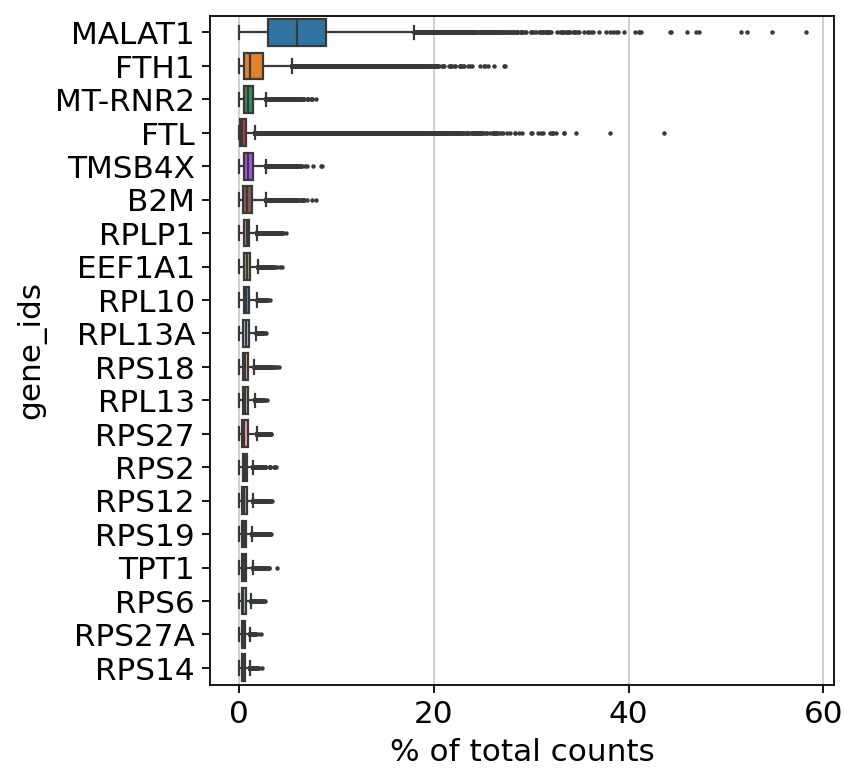

In [45]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


In [46]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(all_adata, min_genes=500)
sc.pp.filter_genes(all_adata, min_cells=3)


filtered out 4 genes that are detected in less than 3 cells


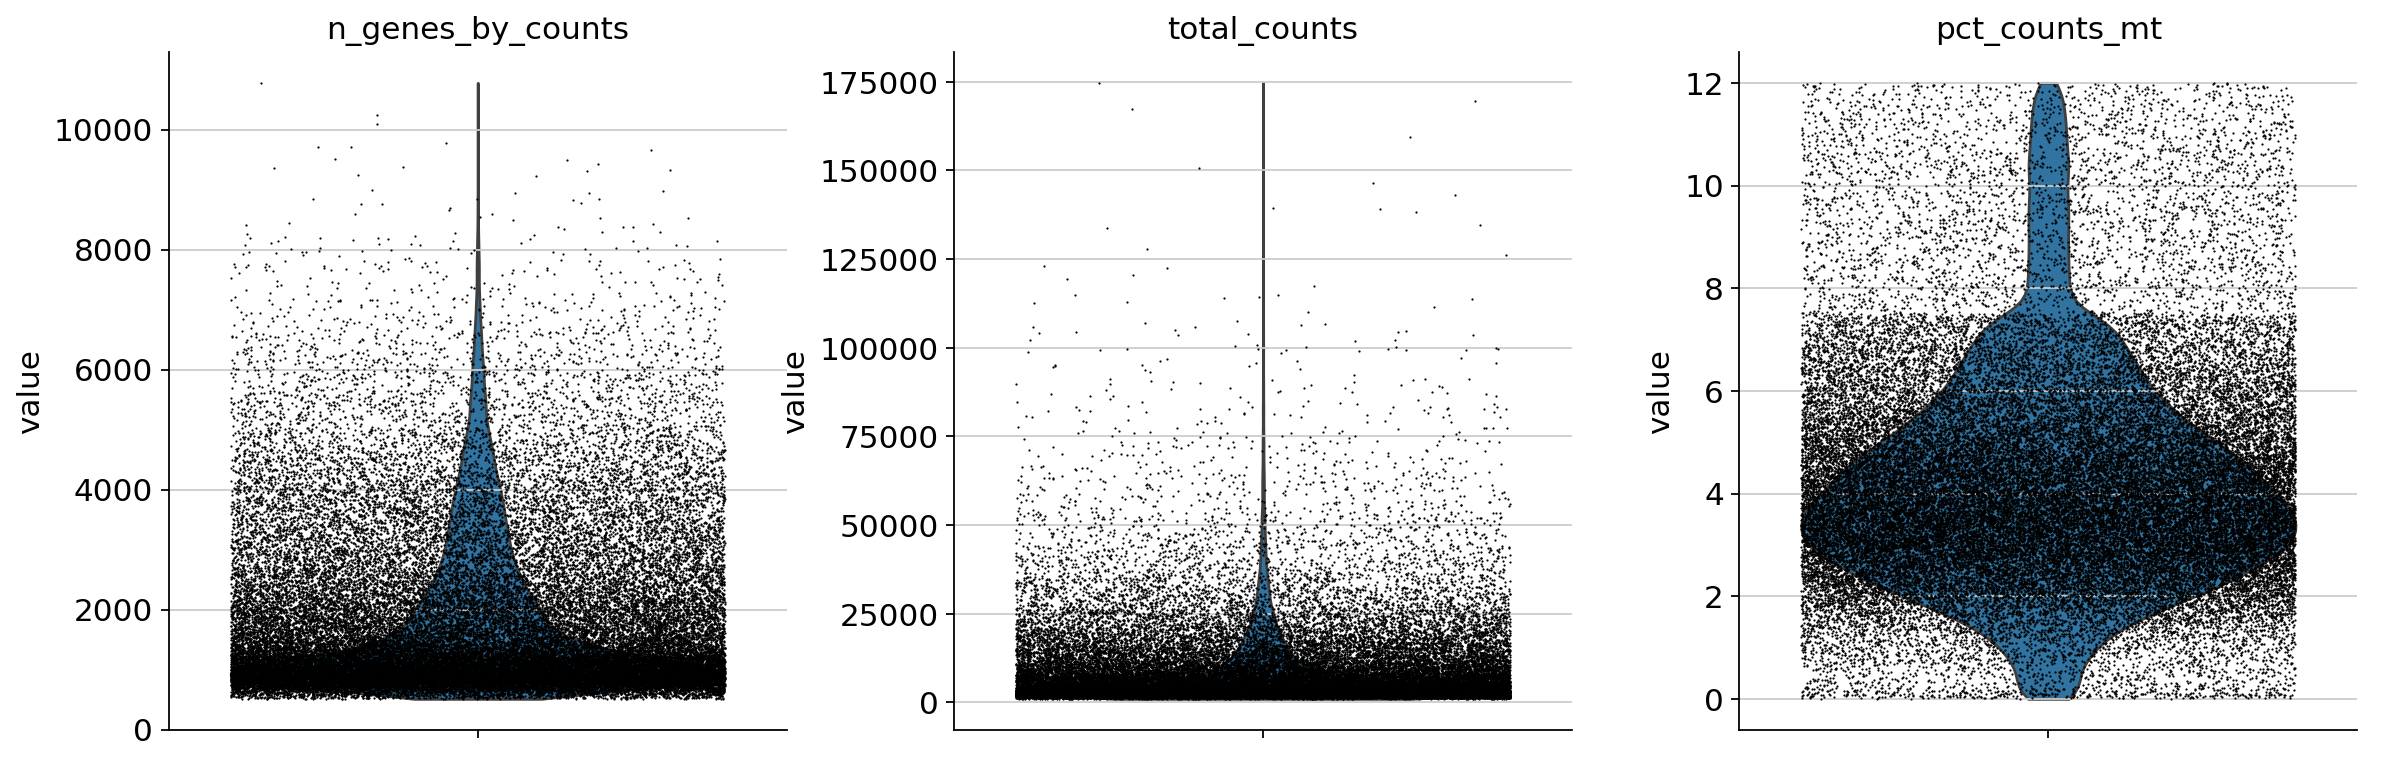

In [47]:
# remove genes with high mitochondrial content
all_adata.var['mt'] = all_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(all_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(all_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

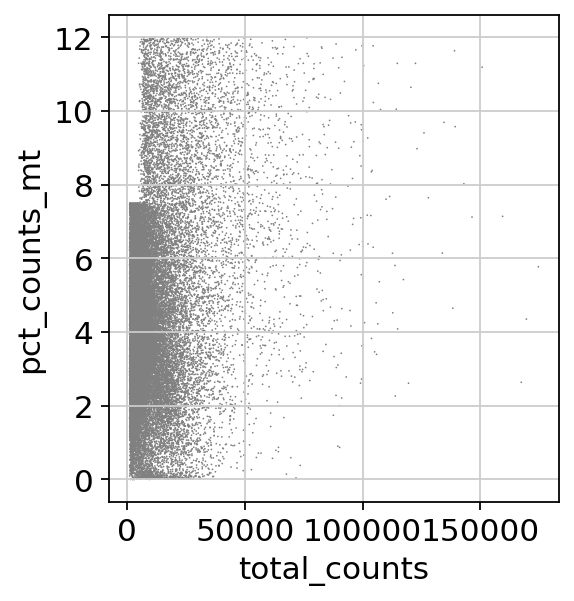

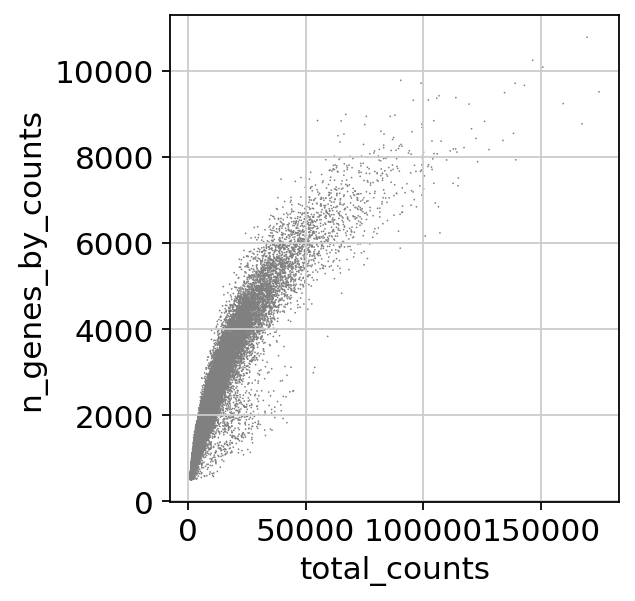

In [48]:
sc.pl.scatter(all_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(all_adata, x='total_counts', y='n_genes_by_counts')

In [49]:
# slice the data based on the plots from above
# remove cells with more than 7000 genes
# remove cells with more than 10% MTgenes
all_adata = all_adata[all_adata.obs.n_genes_by_counts < 8000, :]
all_adata = all_adata[all_adata.obs.pct_counts_mt < 10, :]

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


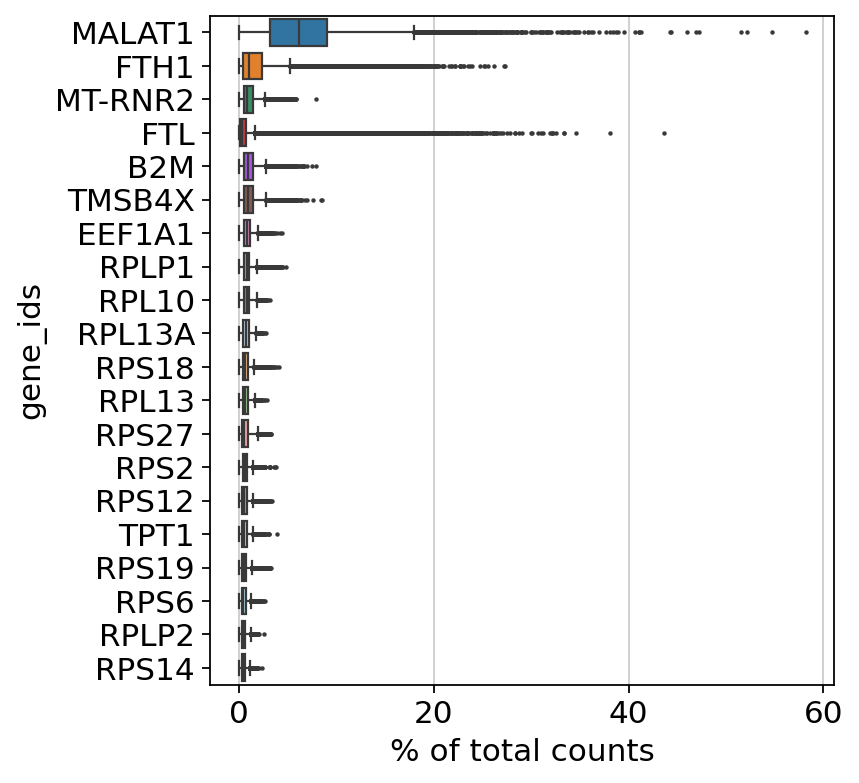

In [50]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


## write it out

In [52]:
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType                   EOC  Immune  Stromal
sample_id                                             
Samp_EOC3_interval_Omentum        182    1884      396
Samp_EOC3_primary_Peritoneum      179    2588      351
Samp_EOC87_interval_Omentum       134     999      301
Samp_EOC87_primary_Peritoneum      95    1079      295
Samp_EOC136_interval_Omentum     2318     769      406
Samp_EOC136_primary_Mesentery     167    1329      967
Samp_EOC153_interval_Omentum      110    1820      465
Samp_EOC153_primary_Omentum       290     641      409
Samp_EOC227_interval_Omentum      165    1813       28
Samp_EOC227_primary_Omentum        45    2089       31
Samp_EOC349_interval_Omentum       58    1401        4
Samp_EOC349_primary_Peritoneum     25    1096      357
Samp_EOC372_interval_Peritoneum    81    2389     2151
Samp_EOC372_primary_Peritoneum    154     288      142
Samp_EOC443_interval_Omentum       85    4107      253
Samp_EOC443_primary_Omentum       770     612      424
Samp_EOC540_interval_Omentum       16    1658      367
Samp_EOC733_interval_Omentum      311    3685       20
Samp_EOC733_primary_Peritoneum   1048     149       43
Samp_EOC1005_interval_Tumor       345     660      210
Samp_EOC1005_primary_Peritoneum   373    2342      242

In [53]:
set(all_adata.obs.cellType)

{'EOC', 'Immune', 'Stromal'}

In [54]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/0_process_sc/../../data/single_cell//GSE165897_processed/GSE165897_processed.h5ad'

In [55]:
# write it out before normalization
all_adata.write(result_ad_file)


# Normalization

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


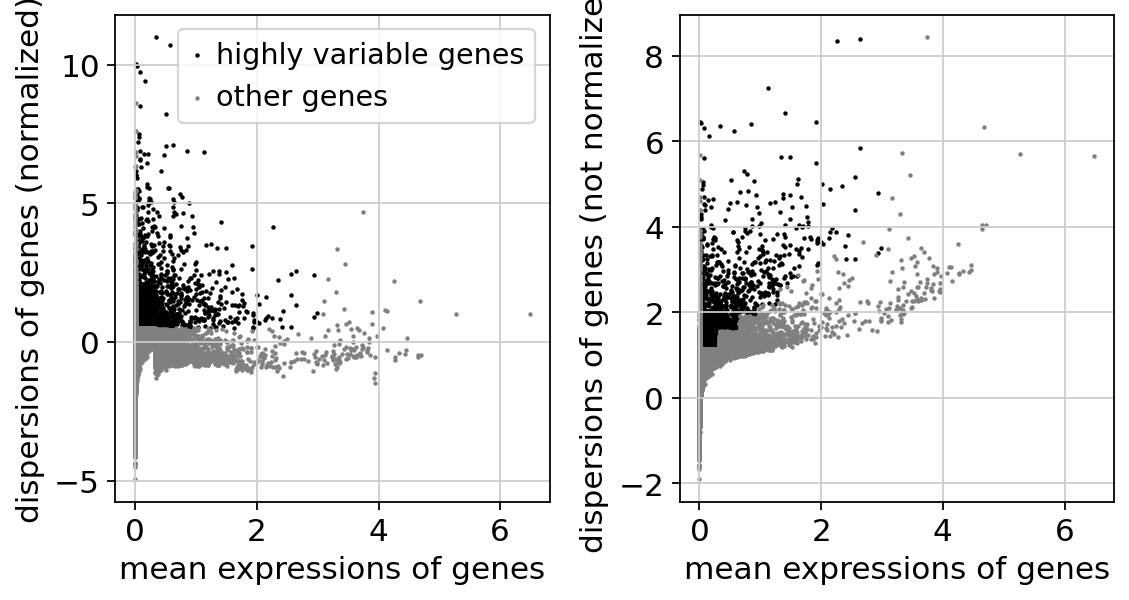

In [56]:
# normalize to 10K counts per cell
sc.pp.normalize_total(all_adata, target_sum=1e4)

# log data
sc.pp.log1p(all_adata)

# get high variance genes
sc.pp.highly_variable_genes(all_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(all_adata)

# now store the raw version of the data for our use later
all_adata.raw = all_adata


In [57]:
# now process the counts further for doing DE 
# analysis and the cell clustering
all_adata = all_adata[:, all_adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(all_adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(all_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:02:19)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# PCA

computing PCA
    with n_comps=50


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


    finished (0:00:21)


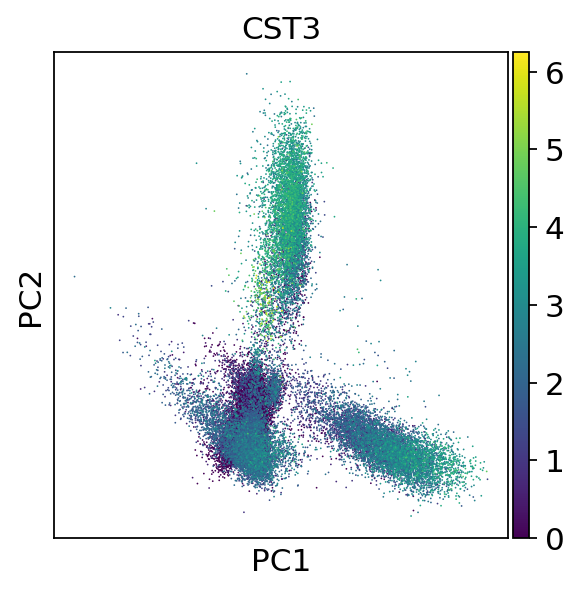

In [58]:
sc.tl.pca(all_adata, n_comps=50)
sc.pl.pca(all_adata, color='CST3')


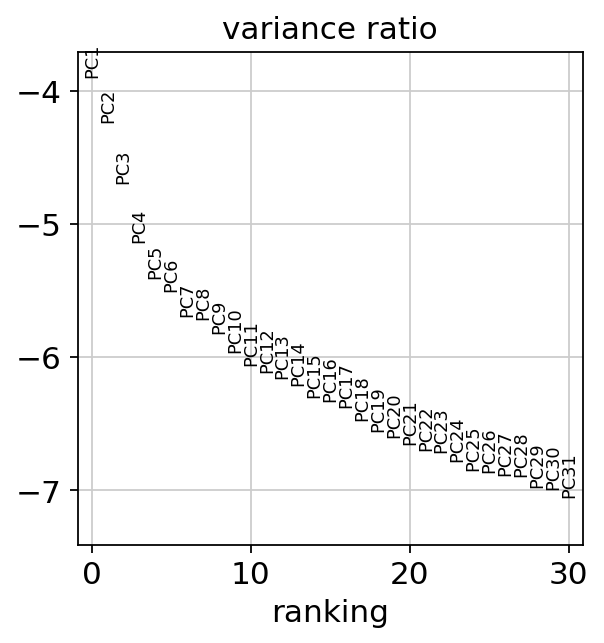

In [59]:
sc.pl.pca_variance_ratio(all_adata, log=True)


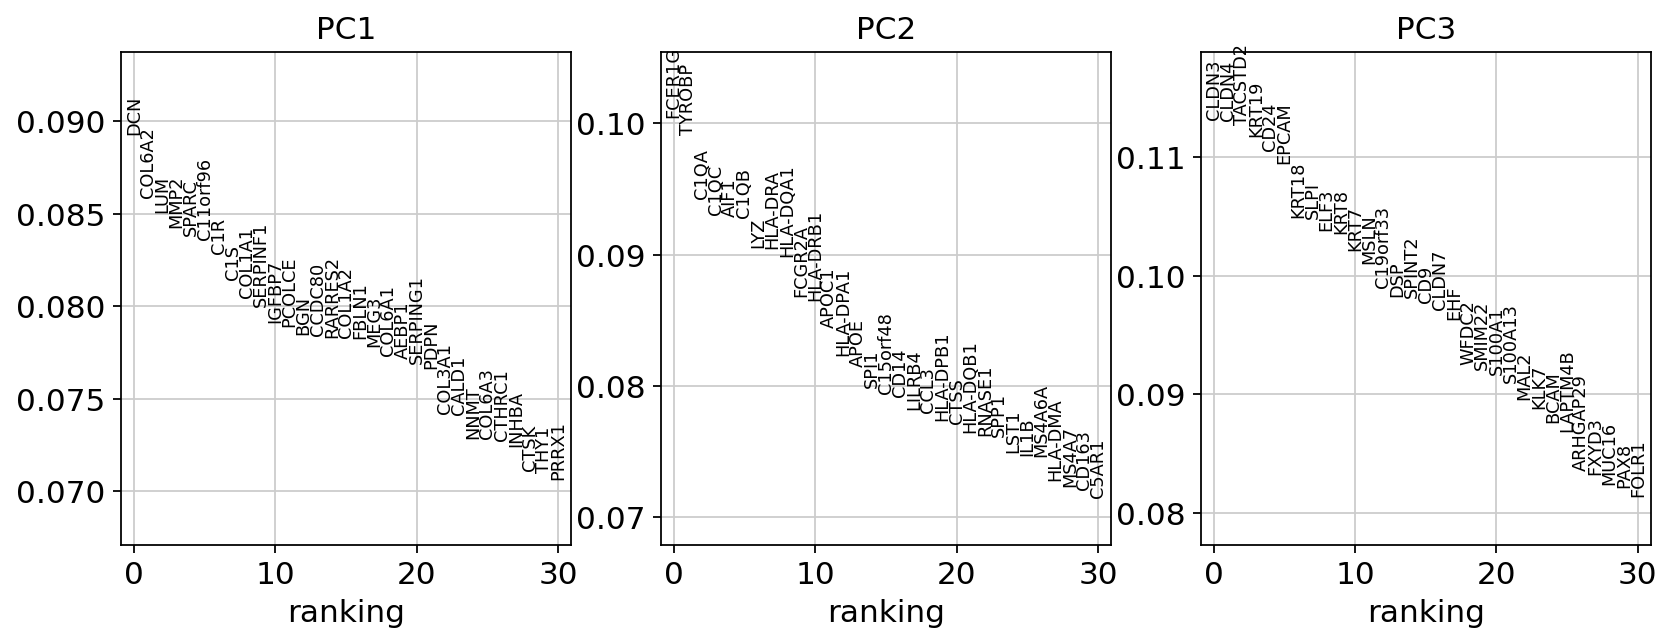

In [60]:
sc.pl.pca_loadings(all_adata, include_lowest=False)


## Compute and embed neighborhood graph

In [61]:
# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)


## Cluster the neighborhood graph

running Leiden clustering


/tmp/ipykernel_2485147/2557792080.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(all_adata, resolution=0.7)


    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


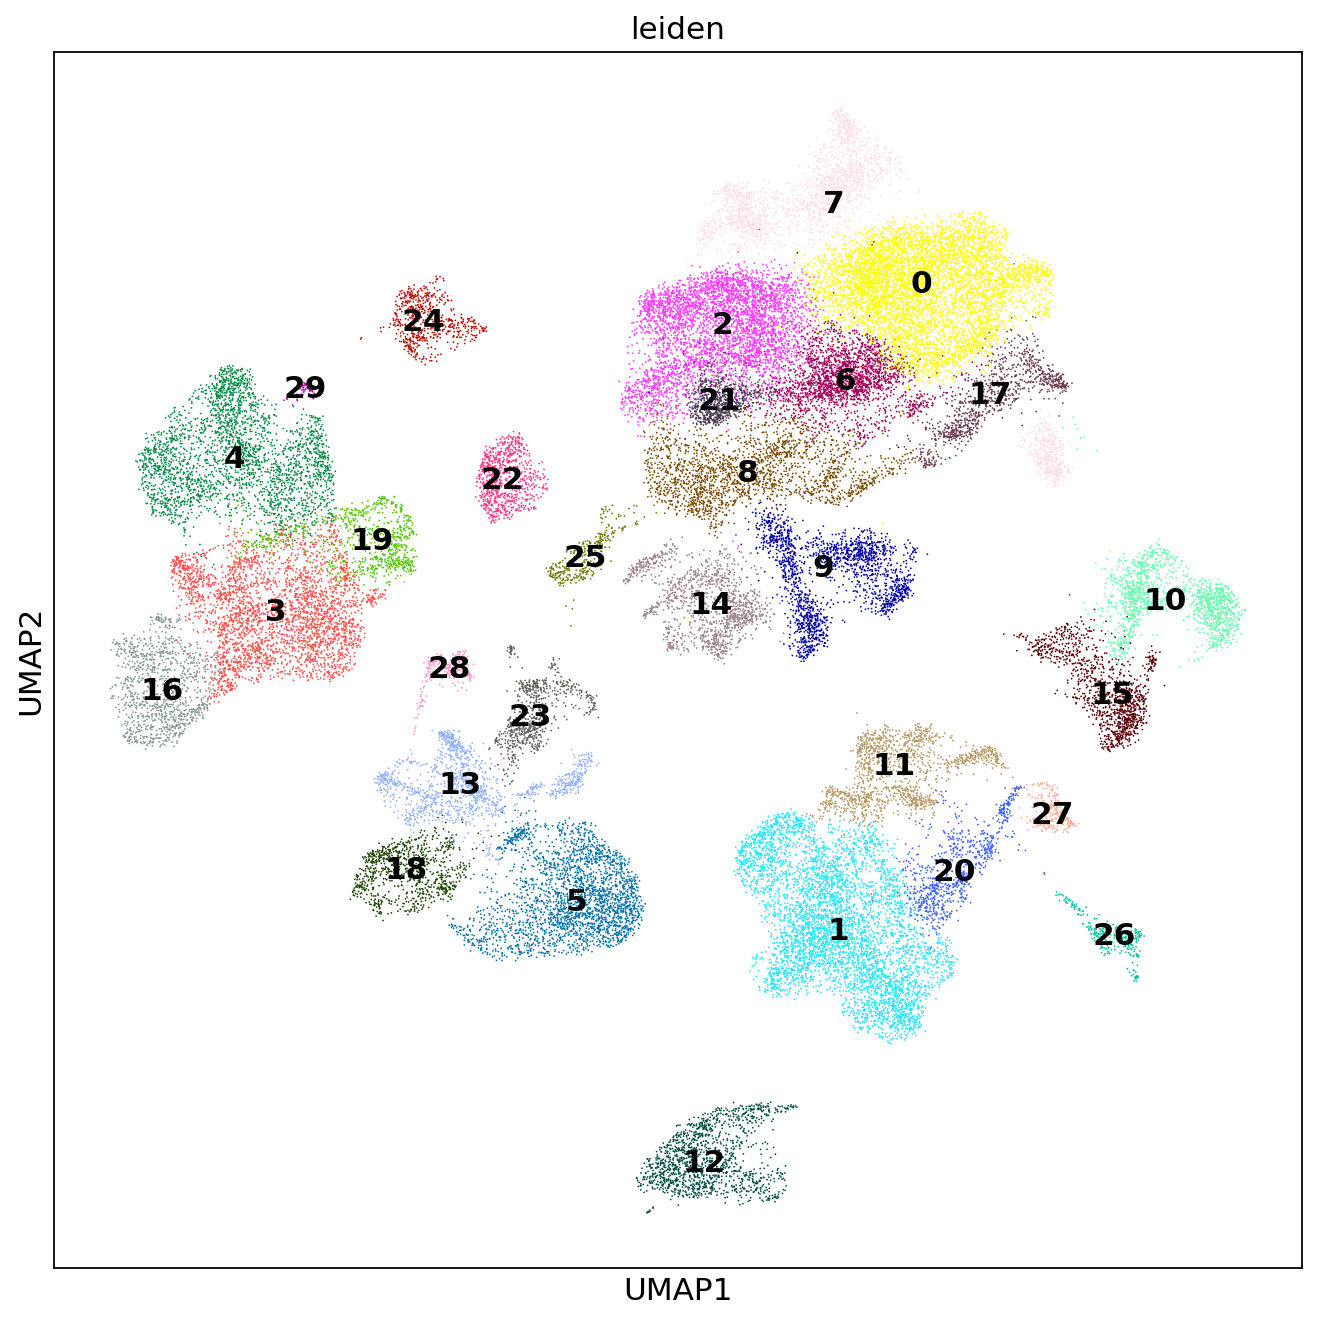

In [62]:
# lets use Leiden clustering
sc.tl.leiden(all_adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='leiden', legend_loc='on data')



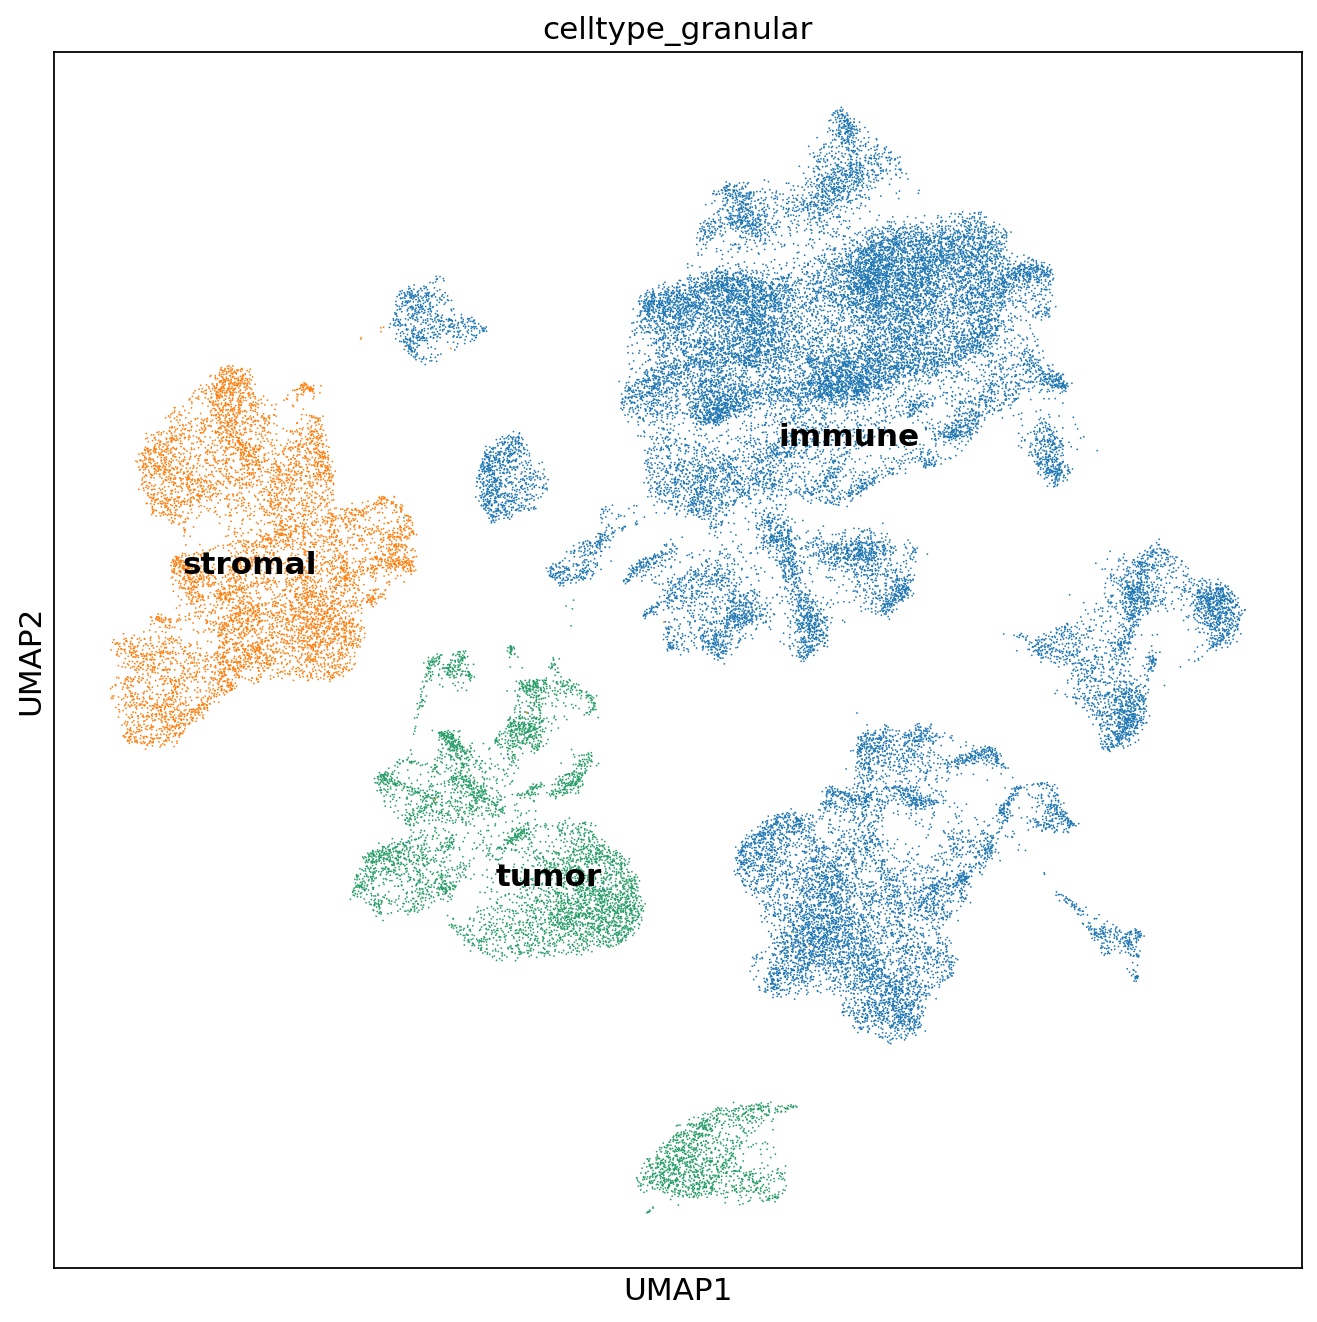

In [63]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='celltype_granular', legend_loc='on data')


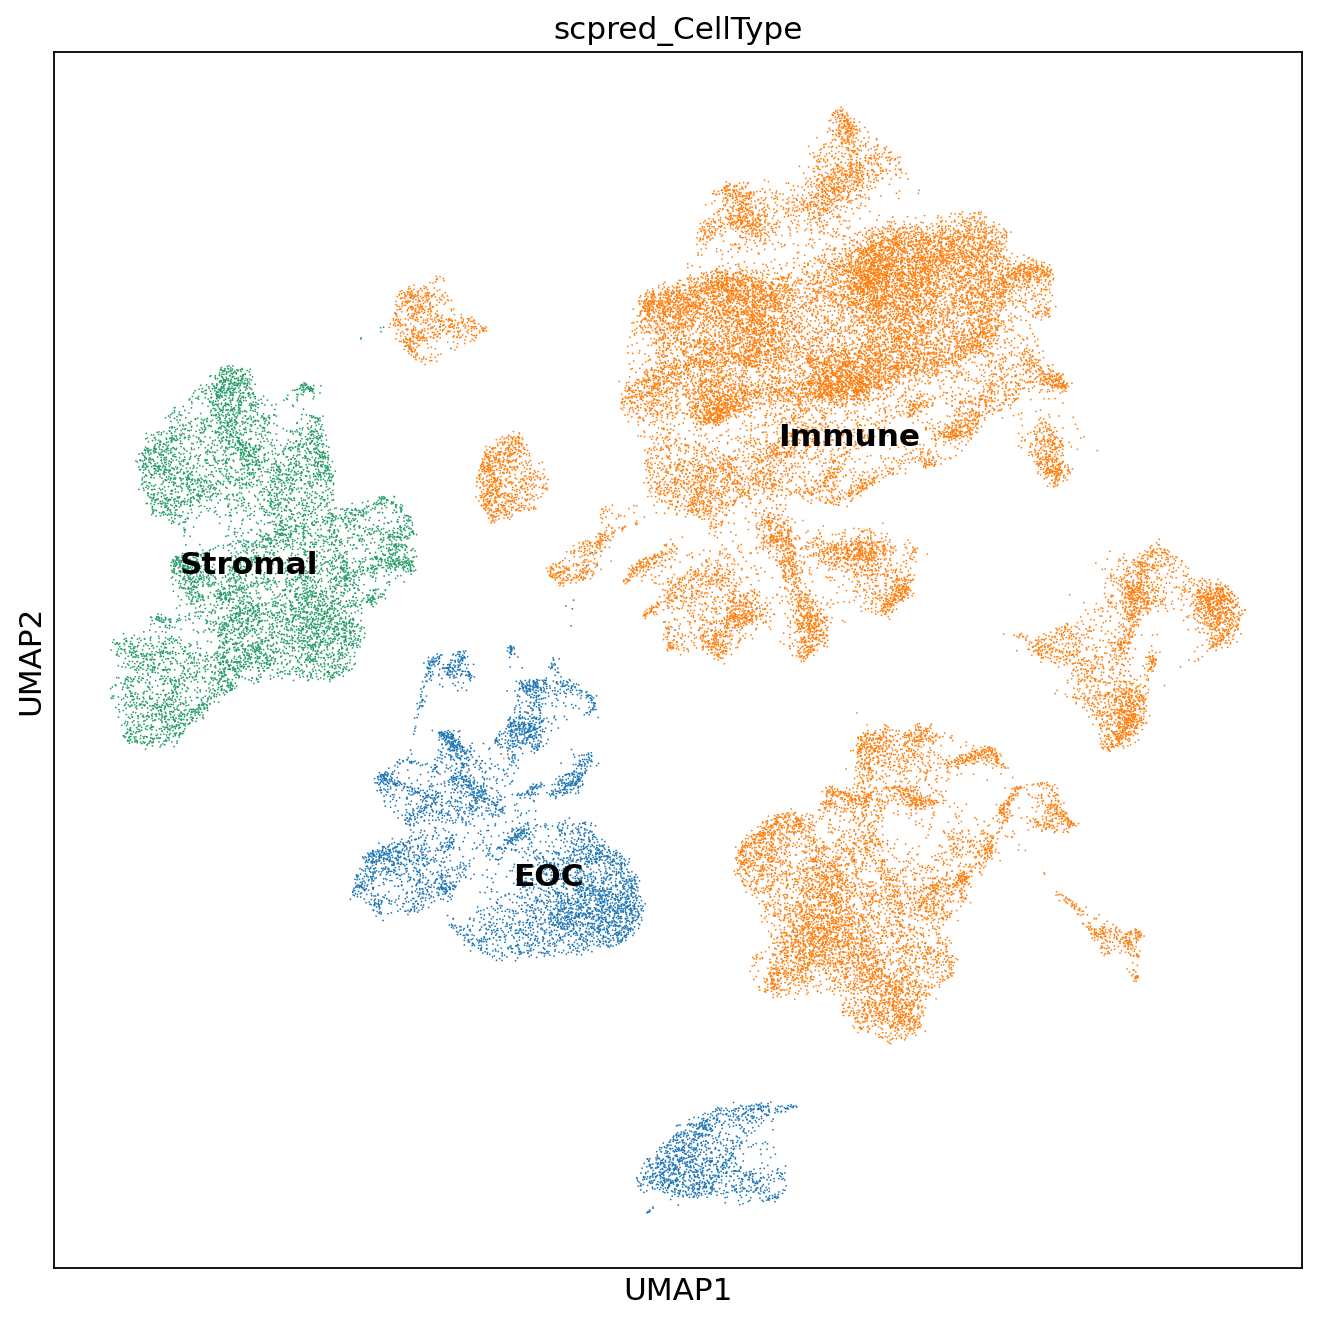

In [64]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='scpred_CellType', legend_loc='on data')


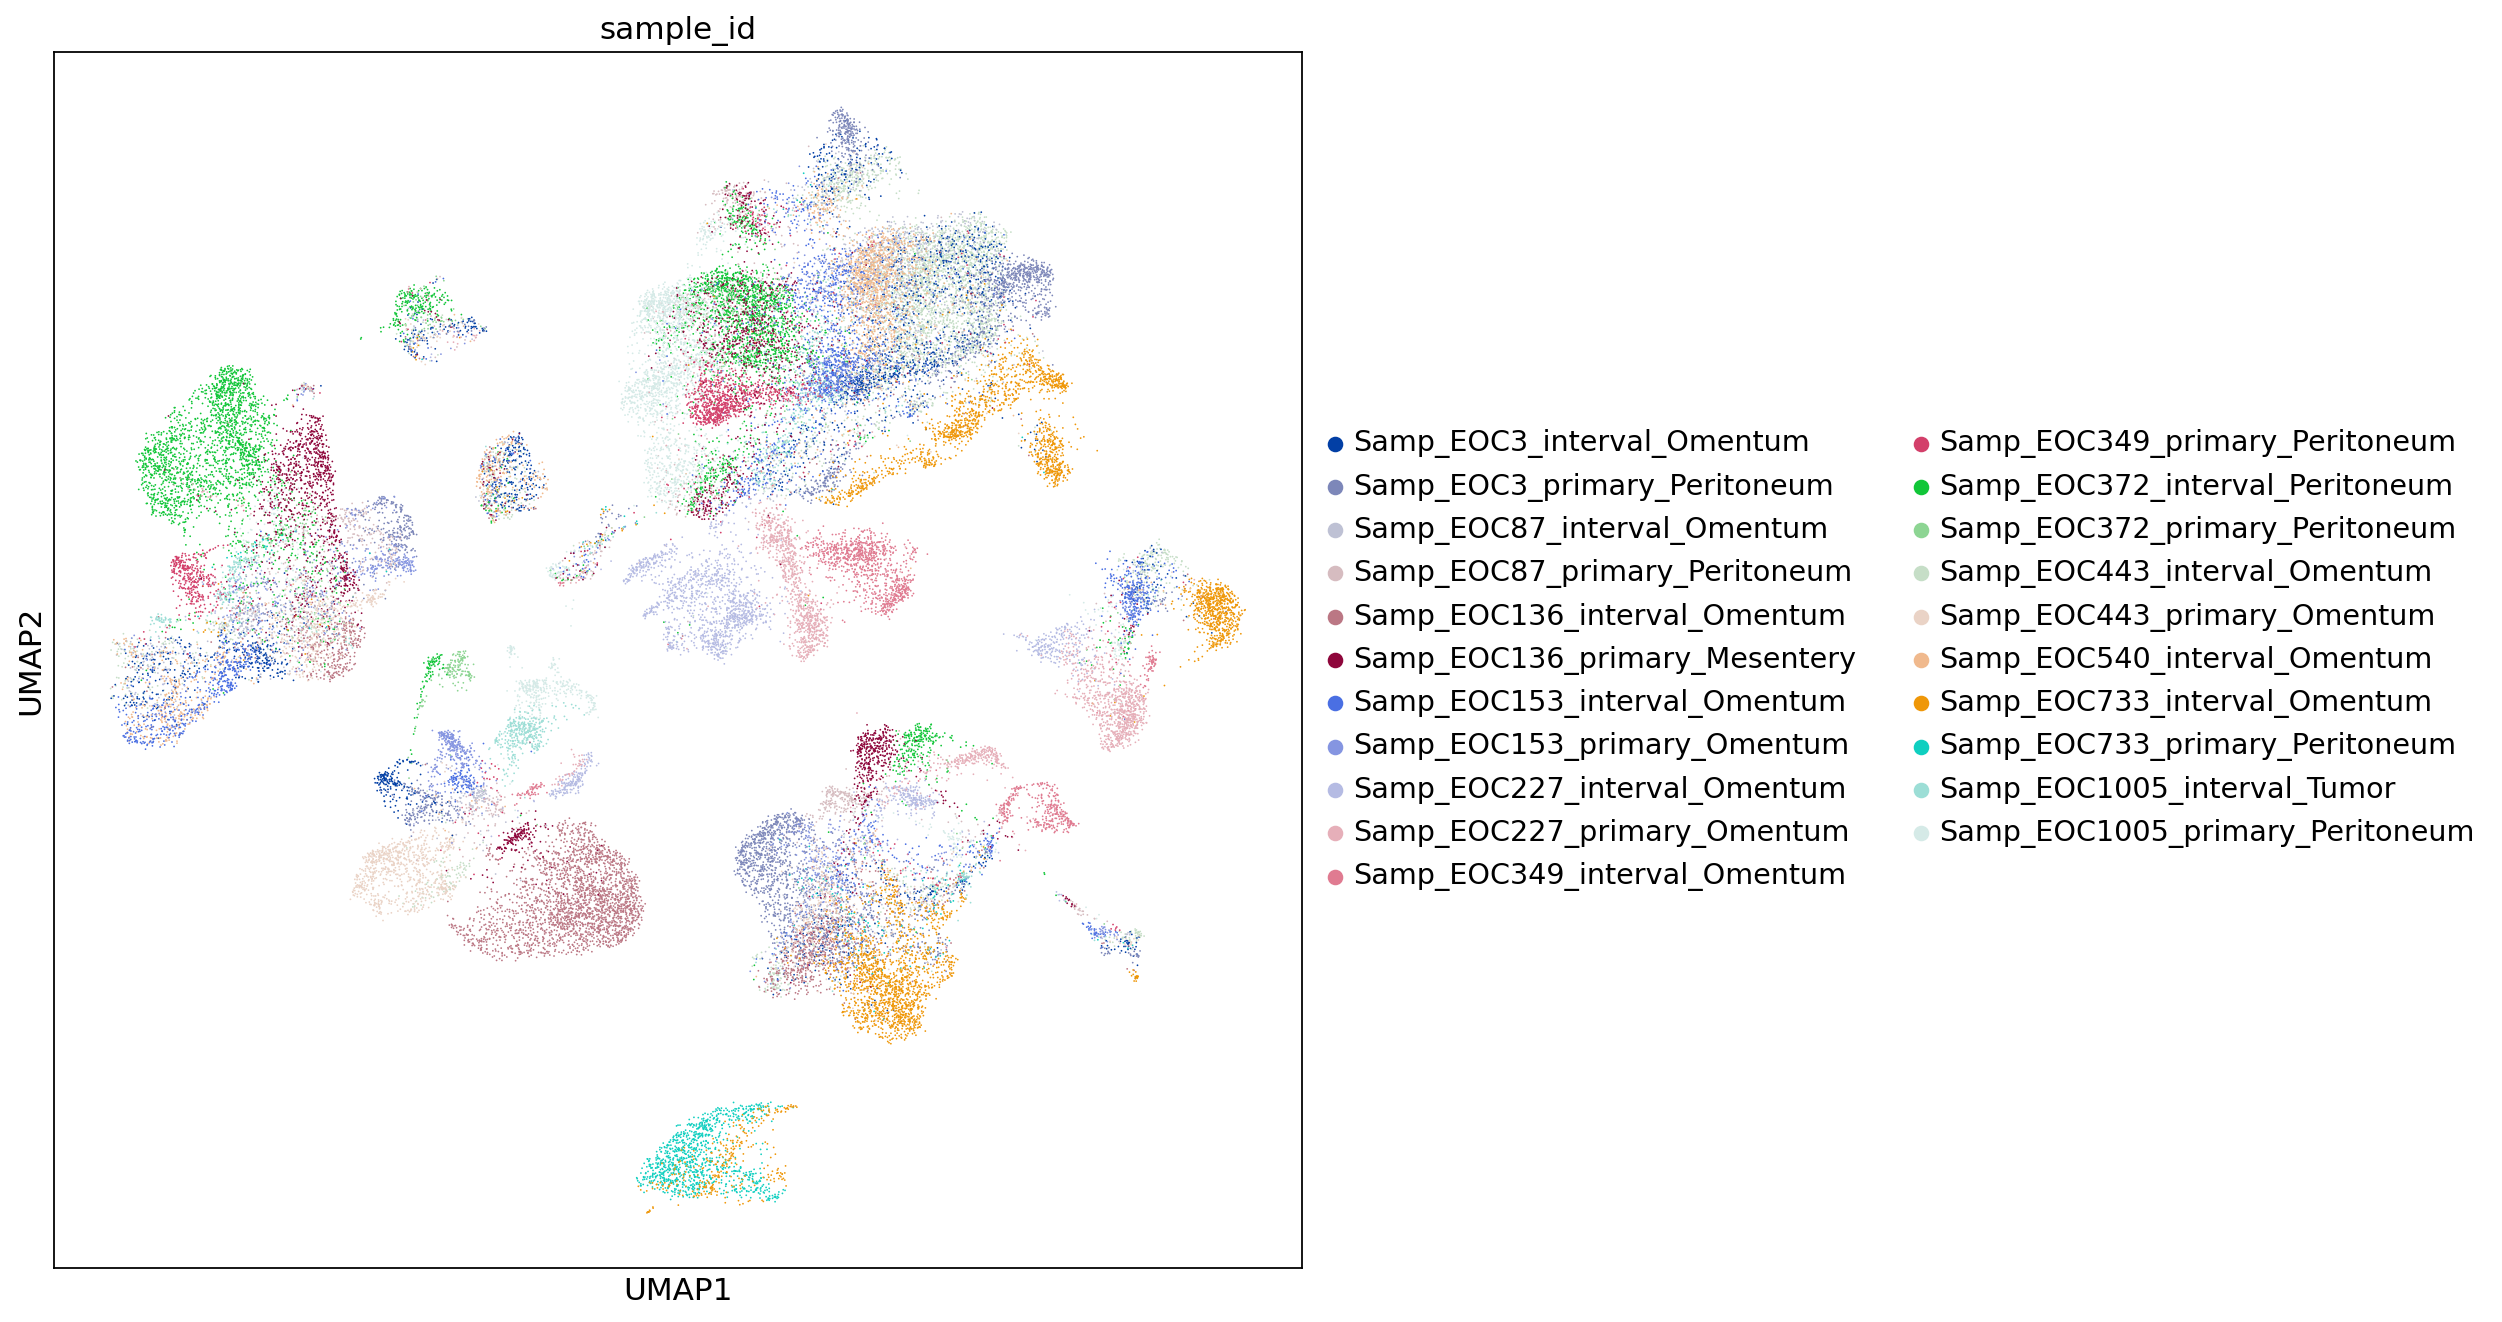

In [66]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='sample_id')


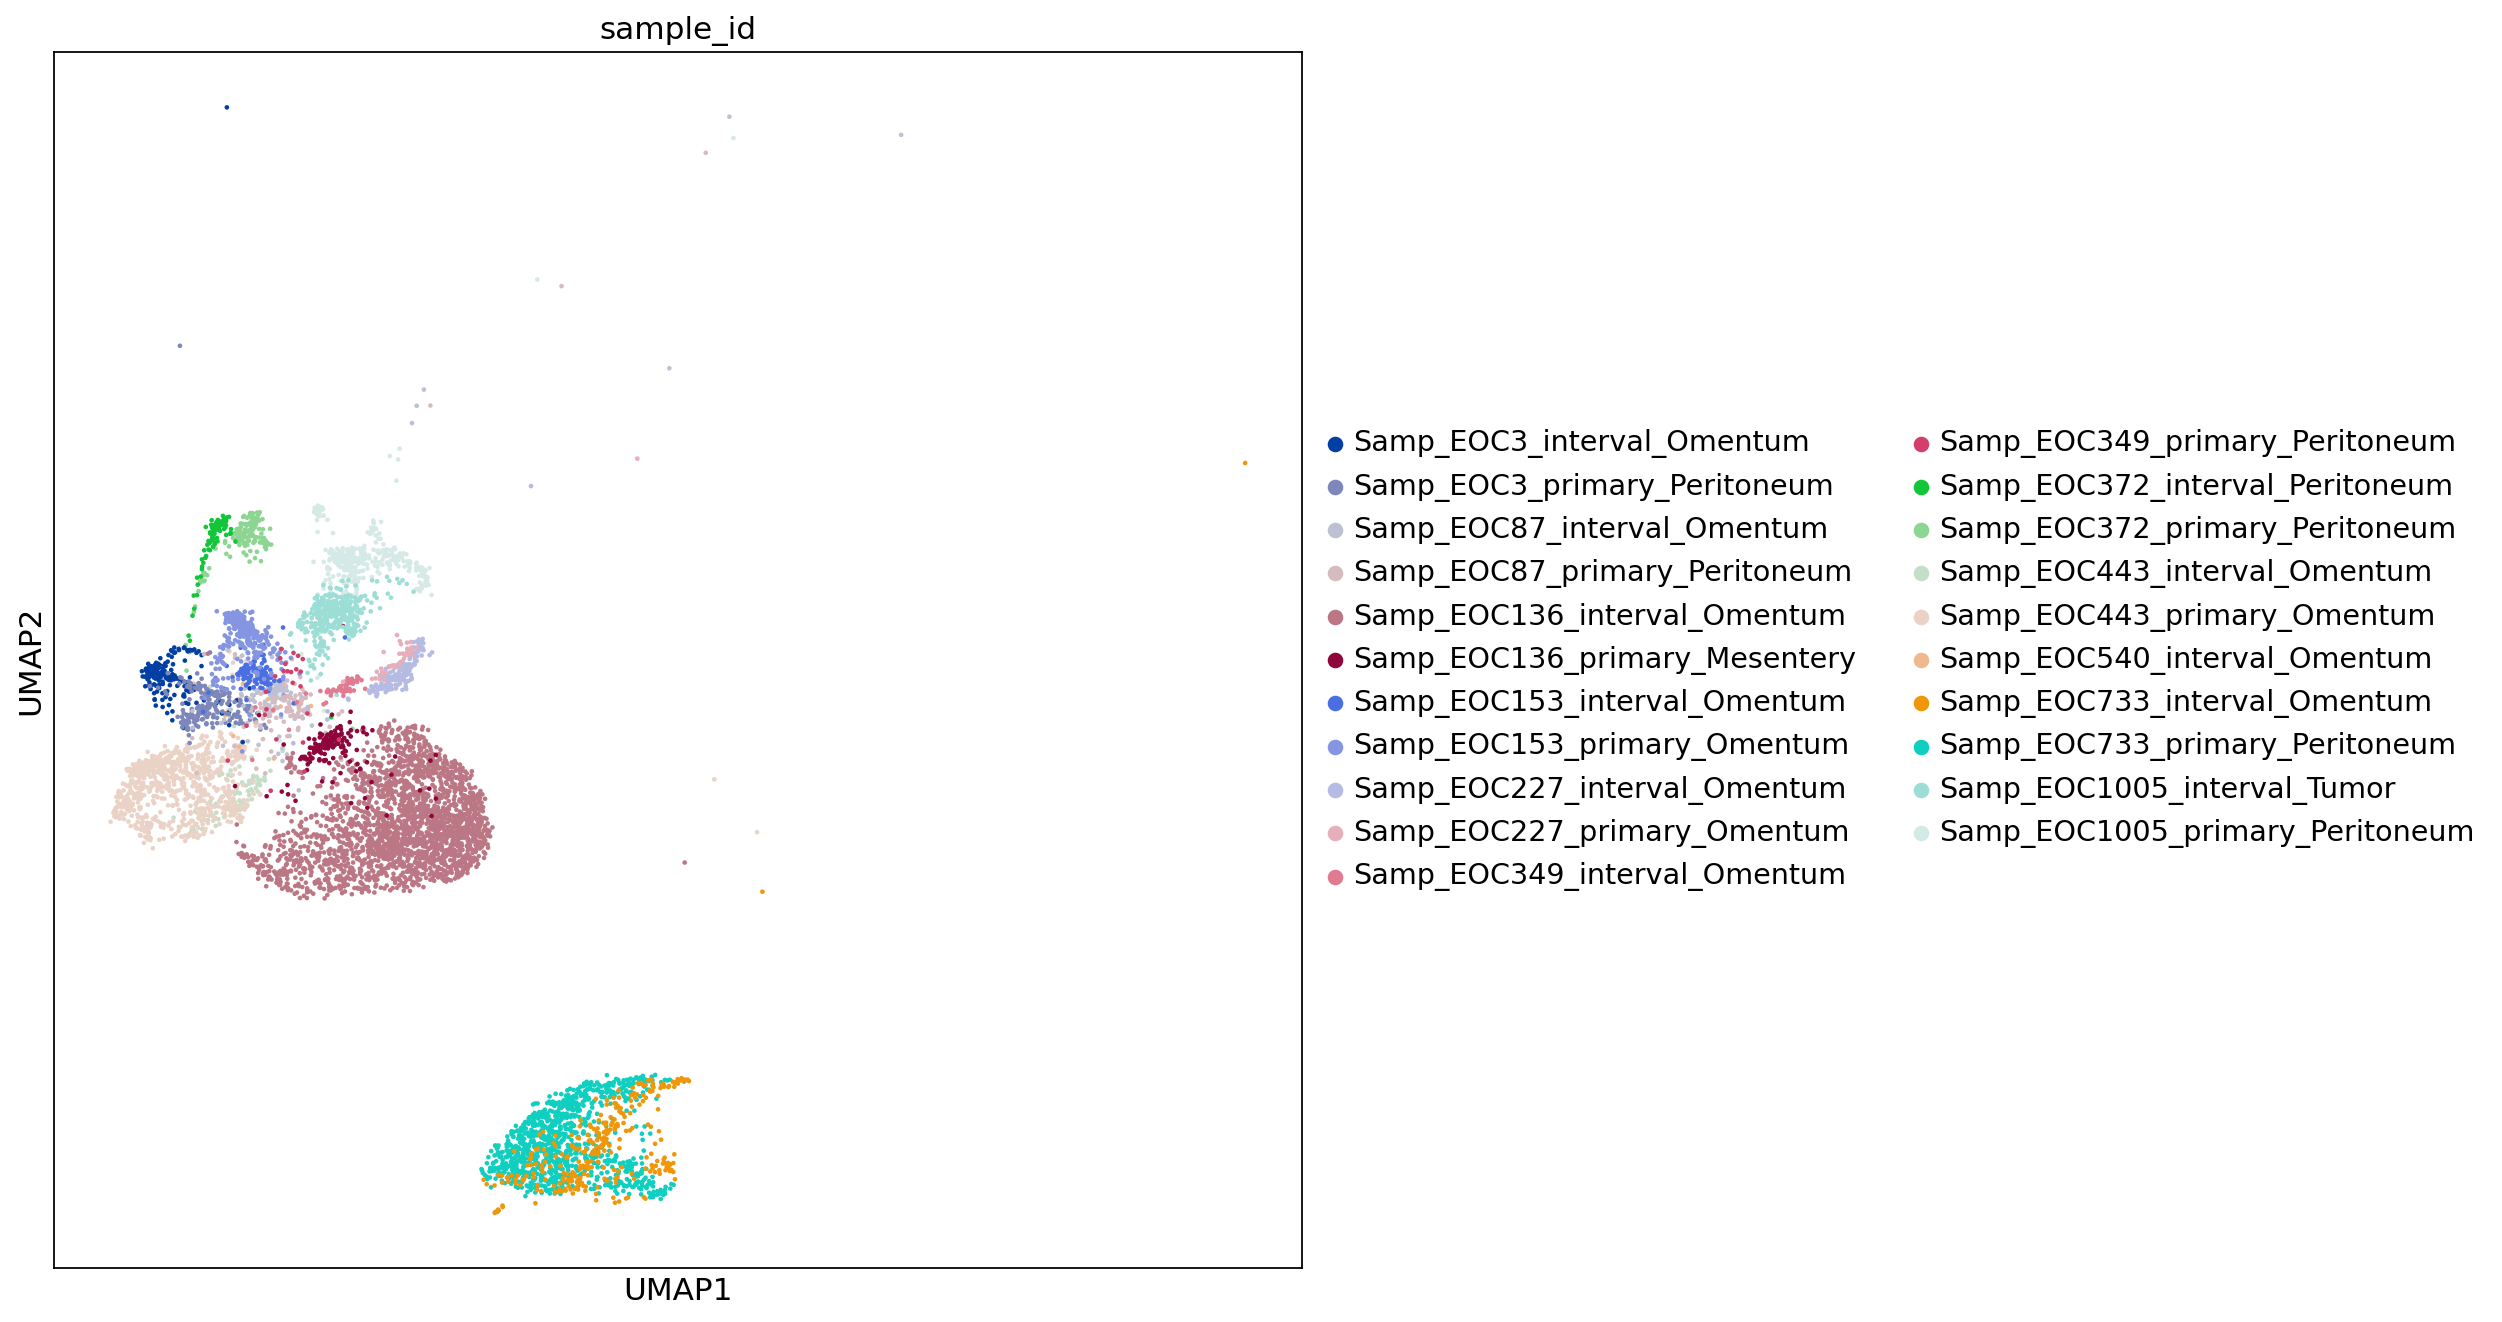

: 

In [ ]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata[np.where(all_adata.obs.celltype_granular == "tumor")[0]], color='sample_id')
